<a href="https://colab.research.google.com/github/andylynchul/ET5003_Assignments/blob/master/Week%201/Etivity_1_ALynch_20208189.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [152]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [153]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20208189" #@param {type:"string"}
Student_full_name = "Andrew Lynch" #@param {type:"string"}
#@markdown ---

In [154]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = Final #@param ["Draft", "Final"] {type:"raw"}
Submission = True #@param {type:"boolean"}

#Introduction
The objective of this exercise was to develop a general-recipe multinomial logistic classifier (GRML) and Bayesian multinomial logistic regression (MLR) classifier to classify samples of handwritten digits into a number of classes. The GRML was used to provide a baseline to allow comparison of the BML and a tuned GRML once the issue of difficult to detect instances was addressed. An intended outcome of the exercise was to gain knowledge of the `degree` of uncertainty attached to a particular production which provides a scale for us to predict on as opposed to the GRML which provides a much stricter classification.
 
## Multinomial Logistic Regression (MLR)
Logistic Regression is concerned with grouping or classifying data. Binomial Logistic Regression is employed when there are only two classes to be applied to the data. The model is trained to assess the probability of a data point being classified belongs to a class usually labeled 1 (or positive). The model uses a binomial probability distribution function. [1] Multinomial logistic Regression is used when there are a number of (more than 2) classes involved. This problem is termed a multi class or multi nominal classification problem. It utilizes Multinomial Probability Distribution. Implementing a MLR classifier requires the use 
 
### Bayesian Multinomial Logistic Regression (BMLR)
BMLR (or Naive Bayes classifiers) are built on the foundation of Bayes Theorem which provides a method to calculate the probability of a hypothesis given prior knowledge. It is represented as follows [4];


$$P(x | y) = \frac{P(x) \ P(y | x)}{P(y)}\$$
 
- $P( x | y)$ is called the _posterior_; this is what we are trying to estimate, 
- $P(y | x)$ is called the _likelihood_; this is the probability of observing the new evidence, given our initial hypothesis, 
- $P(x)$ is called the _prior_; this is the probability of our hypothesis without any additional prior information,
- $P(y)$ is called the _marginal likelihood_; this is the total probability of observing the evidence.

**[Notation taken from [4]]**

Bayes Theorem allows us to calculate the Posterior Probability of an event (or data point being part of a class) based on evidence / prior information. This Posterior is used as a degree of uncertainty to allow the ML system to classify the data point into one of the defined classes. In this particular case it can used to classify the samples but also provide a rank in terms of how difficult it was to classify the data allowing for more control of how to handle such cases.


 
 
 
 
 



## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Libraries

In [155]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [156]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
from scipy.special import erf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az
from scipy.io import loadmat
import pymc3 as pm
import random
import theano as tt
from sklearn.utils import shuffle
from skimage.color import rgb2gray

In [157]:
# Setting a seed:
np.random.seed(321)

## Dataset

### Loading the MNIST dataset

In [158]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [159]:
# Path, copy the path from your Drive
Path = '/content/drive/MyDrive/Masters/Year2/ET5003/Week1/Mnist Data/'

# MNIST Data
train_data = Path + 'mnist_train.csv'
test_data = Path + 'mnist_test.csv'

# train data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values
print(X_train.shape)

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values
print(X_test.shape)

(60000, 784)
(10000, 784)


In [160]:
print(X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

In [161]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)

print(minv,maxv)

0.0 1.0


### Description of Data:

In [162]:
# Number of examples
n_train =  len(X_train)
n_test =  len(X_test)

# Shape of an image
image_shape = X_train.shape[1]

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)

Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10


### Class Distribution:

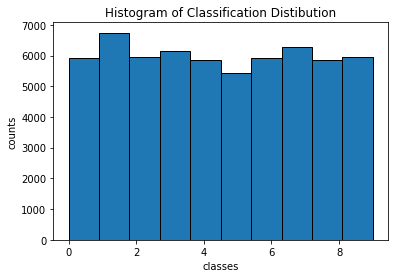

In [163]:
fig, ax = plt.subplots()
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, ec='black', align='mid')
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Classification Distibution')
plt.show()

## Downsampling

### Randomly selecting 3 of the 10 Digit Classes

In [164]:
# We select the number of Classes we want:
n_classes = 3

# Empty list to append the random digit classes we select:
classes = []

# We select 3 digits at random and make sure they are unique:
while len(classes) < n_classes:
    
    # Randomly drawing a digit from 0-9:
    num2choose = np.random.randint(0,10)

    # Append the digit if it's not already in our list of classes:
    if num2choose not in classes: 
      classes.append(num2choose)
        
        
# Sorting the Classes smallest to largest    
classes.sort()
# print classes selected
classes

[4, 8, 9]

In [165]:
# The number of instances we'll keep for each of our 3 digits:
inst_class = 1500

#declare empty list for digits / labels
inputs = []
labels = []

# Loop to randomly sample the instances for each digit:
for r in classes:
    imgs = X_train[np.where(y_train==r)[0],:]
    inputs.append(imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:])
    labels.append(np.ones(inst_class)*r) 

# Shaping inputs and labels in the right format    
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)

New Classes Distribution

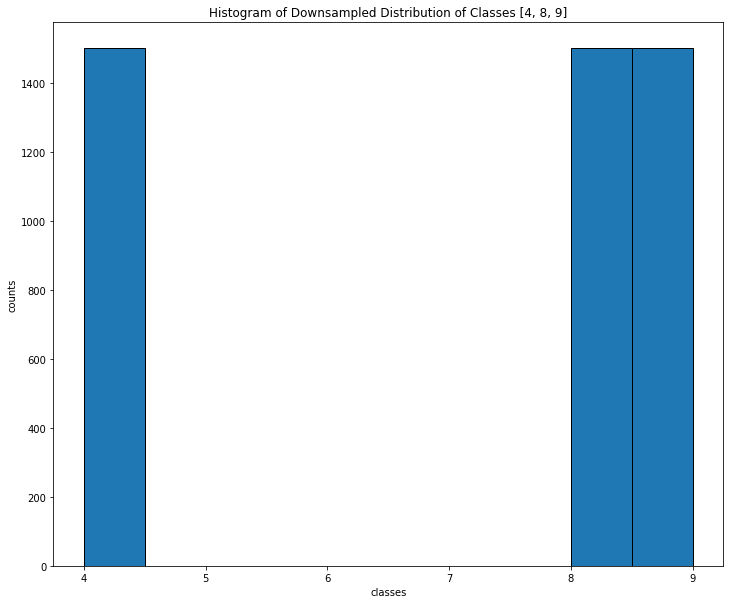

In [166]:
# new histogram

fig, ax = plt.subplots(figsize=(12,10))
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, ec='black', align='mid')
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Downsampled Distribution of Classes '+ str(classes))
plt.show()

In [167]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

Text(0.5, 1.0, 'Seelction Original Data Points (Images)')

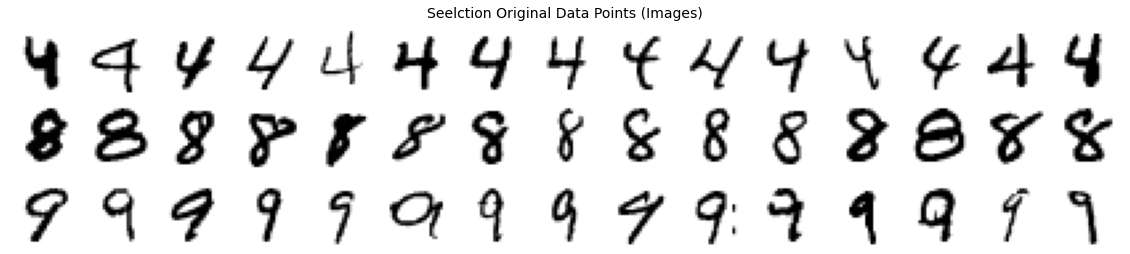

In [168]:
# Show a few instances from each Digit:
plt.figure(figsize=(20,8))
show_i = 15

# Selecting a few label indices from each of the 3 classes to show:
label_indices = []
for r in classes:
    selected_indices = (np.where(y_train==r)[0][:show_i]).tolist()
    label_indices.extend(selected_indices)

label_indices
# Plotting 'original' image
plot_digits(X_train[label_indices,:],images_per_row=show_i)
plt.title("Seelction Original Data Points (Images)", fontsize=14)

###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [169]:
### Split tha dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

In [170]:
# print shape of your validation and training set
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)



(3600, 784)
(900, 784)
(3600,)
(900,)


### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

### General-Recipe ML Solution

In [171]:
# model
model_log = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

# Classification:
y_pred_log = model_log.predict(X_val)
y_pred_logi_prob = model_log.predict_proba(X_val)

# Taking the maximum probability in any of the classes for each observation
prob_classmax = np.max(y_pred_logi_prob,axis=1)

# Computing the Accuracy:
accuracy_score(y_pred_log, y_val)

0.9488888888888889

###Test Accuracy of General-Recipie ML Solution

In [172]:
# Computing the Accuracy:
print(classification_report(y_pred_log, y_val))

              precision    recall  f1-score   support

         4.0       0.95      0.95      0.95       301
         8.0       0.94      0.96      0.95       304
         9.0       0.95      0.94      0.94       295

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



In [221]:
# probability of general-recipe logistic regression in wrong instances
np.sort(prob_classmax)

#show the probabilities of the mis-classified images
print("No of Misclassifications : " + str(len(prob_classmax[y_pred_log!=y_val])))

#get the mean of the probabbilty (Threshold for exclusion)
exclusion_threshold = np.mean(prob_classmax[y_pred_log!=y_val],axis=0)
#print("Exclusion Threshold : " + str(exclusion_threshold))

#Query to see how many images fall below this threshold
difficult_items = np.where(prob_classmax < exclusion_threshold)

#print("Indices to Exclude : " + str(difficult_items[0]))
#print("No of Items Excluded : " + str(len(difficult_items[0])))


No of Misclassifications : 46


### Probabilistic Multinomial Logistic Regression:

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


In [174]:
import sklearn.preprocessing
## We use LabelBinarizer to transfer classes into counts
# neg_label=0, pos_label=1 
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train.reshape(-1,1))

nf = X_train.shape[1]

# number of classes
nc = len(classes)

# floatX = float32
floatX = tt.config.floatX

#generating the seed data for the MLR
init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)

with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β],axis=1)
    α1  = tt.tensor.concatenate([[0],α],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_train,β1) + α1

    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)

    approx = pm.fit(5000, method='advi')

Finished [100%]: Average Loss = 10,435


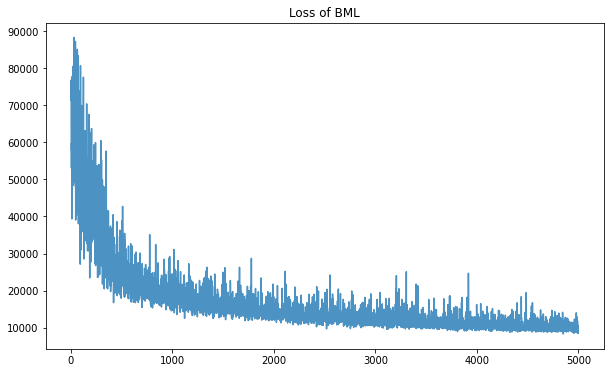

In [175]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(approx.hist, alpha=0.8)
ax.set_title("Loss of BML")
plt.show()

In [176]:
dd = 300
posterior = approx.sample(draws=dd)

test image #742
posterior sample #93
true class= 4.0
classes: [4, 8, 9]
estimated prob= [0.91393562 0.00000173 0.08606265]


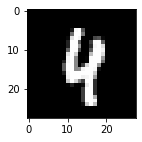

In [177]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

#select an image in the test set
i = random.randint(0, X_val.shape[0])

#select a sample in the posterior
s = random.randint(0, dd)

beta  = np.hstack([np.zeros((nf,1)), posterior['beta'][s,:]])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
image = X_val[i,:].reshape(28,28)
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

In [178]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in range(X_val.shape[0]):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)), posterior['beta'][s,:]])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_val[i,:].dot(beta) + alpha])))

        #print(s,val)
    
    mean_probability = val/posterior['beta'].shape[0]

    #print(i, mean_probability)
    
    y_pred_Bayesian.append(np.argmax(mean_probability))

In [179]:
#recall the classes we are using
print(classes)

[4, 8, 9]


In [180]:
# prediction array (using classes)
nn = 20 # just an example
np.array(classes)[y_pred_Bayesian[0:nn]]

array([8, 8, 8, 8, 8, 8, 4, 4, 4, 4, 8, 9, 8, 9, 9, 8, 4, 9, 8, 8])

In [181]:
# using validation: y_val
print("Accuracy=", accuracy_score(np.array(classes)[y_pred_Bayesian], y_val))

Accuracy= 0.9011111111111111


In [182]:
y_predB=[]

for i in range(X_val.shape[0]):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks*0  #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

y_predB= np.array(y_predB)
    

In [183]:
y_predB.shape

(900, 3)

In [184]:
# prediction array
mm = 10
y_predB[0:mm,:]

array([[1.        , 0.72048852, 0.44221664],
       [1.        , 0.99668285, 0.05763872],
       [1.        , 0.96774179, 0.17058722],
       [1.        , 0.9956501 , 0.08137704],
       [1.        , 0.99828093, 0.        ],
       [1.        , 0.53581302, 0.49553562],
       [0.        , 0.88841581, 0.3       ],
       [0.        , 0.40423505, 0.49243161],
       [0.        , 0.73580175, 0.43679387],
       [0.        , 0.69264435, 0.4552899 ]])

In [185]:
#sorting in descending order
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[2.        , 0.49852872, 0.49998889],
       [2.        , 0.50943898, 0.49998889],
       [0.        , 0.49144297, 0.49998889],
       [0.        , 0.51355982, 0.49995555],
       [1.        , 0.49204392, 0.49995555],
       [0.        , 0.48966055, 0.49995555],
       [2.        , 0.49677194, 0.49989999],
       [2.        , 0.49081751, 0.49989999],
       [2.        , 0.50014728, 0.49982219],
       [2.        , 0.48607935, 0.49982219]])

In [186]:
# probability of general-recipe logistic regression in wrong instances
print(prob_classmax[y_pred_log!=y_val])


[0.98846377 0.64337831 0.99333604 0.89950939 0.82310903 0.72330941
 0.99992331 0.99995801 0.99999988 0.51229803 0.99051143 0.97580973
 0.96928859 0.99999953 0.97400777 0.99491211 1.         0.99305061
 0.99703231 0.98529368 0.75475583 0.9232436  0.82065409 0.91530957
 0.8740901  0.9947946  0.51249674 0.99996935 0.86105232 0.99999195
 0.999981   0.99062947 0.99816002 0.58037703 0.95939365 1.
 0.83141913 0.79678629 0.99999448 0.99999189 0.76965464 0.9384487
 0.70478107 0.99999986 0.933874   0.99999294]


In [187]:
y_predB[y_pred_log != y_val,:]

array([[1.        , 0.71765418, 0.44221664],
       [1.        , 0.98005325, 0.11469767],
       [1.        , 0.8888691 , 0.3       ],
       [2.        , 0.49081751, 0.49989999],
       [2.        , 0.87379268, 0.3       ],
       [1.        , 0.81611494, 0.3756328 ],
       [2.        , 0.97788547, 0.1280191 ],
       [1.        , 0.7608856 , 0.41647996],
       [0.        , 0.54643969, 0.49677851],
       [2.        , 0.96658139, 0.15095989],
       [1.        , 0.73957678, 0.41867516],
       [2.        , 0.55929211, 0.49597267],
       [0.        , 0.61764592, 0.48455019],
       [2.        , 0.79362726, 0.39747816],
       [0.        , 0.62114355, 0.48368952],
       [2.        , 0.88624585, 0.30439375],
       [1.        , 0.96282936, 0.18794207],
       [0.        , 0.5186108 , 0.49982219],
       [2.        , 0.81120891, 0.37853519],
       [1.        , 0.64344384, 0.46647615],
       [2.        , 0.80351276, 0.38418745],
       [0.        , 0.68425547, 0.46110977],
       [1.

In [188]:
## Difficult & easy instances

easy = np.argsort(y_predB[:,2])
print("Accuracy for all instances =", accuracy_score(y_pred_log, y_val))

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_log[easy[0:100]], y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_log[difficult[0:100]], y_val[difficult[0:100]]))

Accuracy for all instances = 0.9488888888888889
Accuracy in easy instances = 1.0
Accuracy in difficult instances = 0.9


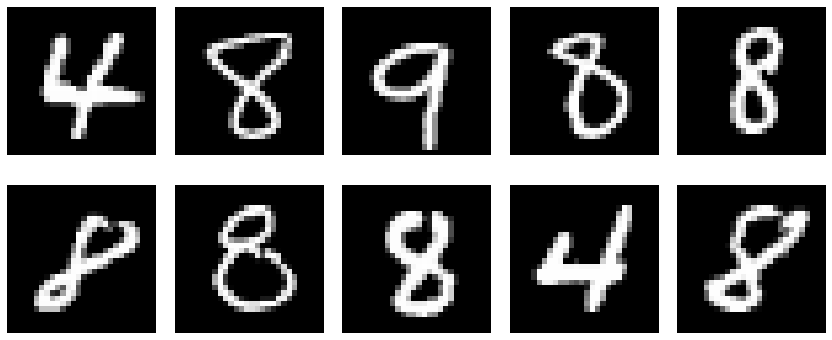

In [189]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

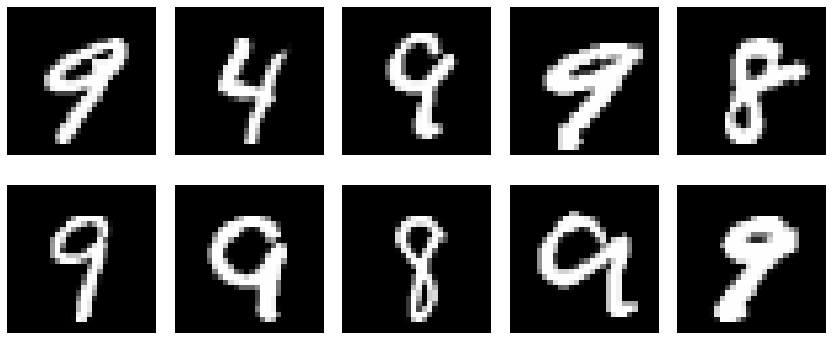

In [190]:
# show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = difficult[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")


## Remove the Difficult Images and Retrain Model

In [217]:
#print(y_predB[2].dtype)

#Calculate the posterior uncertainty of the misclassified items and create a threshold to remove images
ex_threshold = np.mean(y_predB[difficult_items[0],:],axis=0)[2]
print(ex_threshold)

#create a new list of images to include to retrain
easy_i = np.where(y_predB[:,2] <= 0.4999)

# create new data set without selectec images
X_val_e = X_val[easy_i[0]]
y_val_e = y_val[easy_i[0]]

# print shape of new data sets
print(X_val_e.shape)
print(y_val_e.shape)


0.34811092473688243
(894, 784)
(894,)


In [218]:
# model
model_log_easier = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_val_e, y_val_e)

# Classification:
y_pred_log_easier = model_log_easier.predict(X_val)
y_pred_log_prob_easier = model_log_easier.predict_proba(X_val)

# Taking the maximum probability in any of the classes for each observation
prob_classmax_easier = np.max(y_pred_log_prob_easier,axis=1)

# Original the Accuracy:
print("Accuracy (Original) : " + str(accuracy_score(y_pred_log, y_val)))

#show the probabilities of the mis-classified images
print("No of Misclassifications (Original) : " + str(len(prob_classmax[y_pred_log!=y_val])))

# Computing the Accuracy:
print("Accuracy (Re-Trained) : " + str(accuracy_score(y_pred_log_easier, y_val)))

#show the probabilities of the mis-classified images
print("No of Misclassifications (Re-Trained) : " + str(len(prob_classmax_easier[y_pred_log_easier!=y_val])))



Accuracy (Original) : 0.9488888888888889
No of Misclassifications (Original) : 46
Accuracy (Re-Trained) : 1.0
No of Misclassifications (Re-Trained) : 0


## Summary

**Practicalities** : I had developed all the Year 1 E-tivities using Visual Studio Code (Anaconda). I switched to Colab for this exercise and found it very good to use. I also switched from GitLab to GitHub to manage source files. I used Google Drive to host the data files as I came up against errors in uploading the files to Colab (size issue).
 
**Dataset** : I approached this e-tivity in a similar fashion to others, using the Traffic Signs Lab as a guide. The initial task was to import and analyse the data set. The initial EDA  of the data set didn't produce any issues. The MNIST dataset provided images of 28×28  pixels and was  well distributed across 10 classes. The testing and training data were in the order of 60K and 10K data points respectively. Each image was made up of a 784 wide vector describing the images as a set of grayscale values (0-255). The only pre-processing step was to normalise the data by dividing all values by 255 to bring them into a range of [0,1. The dataset was quite large so I downsampled the data 1) by selecting 3 digits out of the 10 to work with and 2) selecting a limited number of samples of the training data to train the system (1500). This was to speed up dev / computation time. The only other pre-processing was to apply the LabelBinarizer() to the downsampled data to one-hot encode the Class labels for processing.
 
**Training / Test Data** : The training data was split using the scikit-learn model_selection module and was done so on a 80/20 split between training and validation data.
 
**Models** I implemented the initial GRML using the scikit-learn library and standard parameter setup. I employed the classification_report module (used in Year 1 E-tivities) to produce fast Precision, Recall and F1-Score data to assess the model. It achieved an overall accuracy of 95%. I also took note of the mis-classified items and used them to try and devise a way to define a threshold to allow us to remove difficult to classify images for removal.
 
The second model devised was the Multinomial Logistic Regression (MLR) solution. This leveraged the Traffic Sign implementation. This was done using the pymc3 module. The MLR model was fitted over 5000 iterations and shows a good reduction in loss and an overall accuracy of 90%. The Bayesian theory allowed the analysis of the standard deviation of the predictions across the classes of all instances allowing the ranking of difficulty in identifying the images successfully. Higer SD = More Difficult.
 
**Removal of Difficult Images** I tried to approach this from a slightly different point of view to try and extend my knowledge and experiment a little. I did some analysis of the mis-classified images from the first pass of the GRML. With these images identified I extracted their data from the ranking module and took the mean of the SD to see if we could identify a threshold that would allow us to remove difficult to identify images from the data set to retrain the GRML. This threshold of SD emerged as 0.35 but made no difference to the overall accuracy of the model. I did however start to manually tune the parameter and it gave me control over how many of the difficult samples were dropped from the data set before the model was retrained. It transpired that by manually tuning this to 0.499 it brought the accuracy to 99.4 (27 data points dropped) and 0.4999 brought it to 100% (6 items dropped)
 
I would have liked to have done further analysis but ran short on time.
 
 
 
 
 
 
 
 
 



###References

1. Brownlee, J. (2020). Multinomial Logistic Regression With Python. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/multinomial-logistic-regression-with-python/.

2. VanderPlas, J. (2019). In Depth: Naive Bayes Classification | Python Data Science Handbook. [online] Github.io. Available at: https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html.

3. Ismiguzel, I. (2021). Naive Bayes Algorithm for Classification. [online] Medium. Available at: https://towardsdatascience.com/naive-bayes-algorithm-for-classification-bc5e98bff4d7 [Accessed 19 Sep. 2021].

4. colab.research.google.com. (n.d.). Google Colaboratory. [online] Available at: https://colab.research.google.com/github/adhiraiyan/DeepLearningWithTF2.0/blob/master/notebooks/03.00-Probability-and-Information-Theory.ipynb#scrollTo=XGYEJ_saDdid [Accessed 19 Sep. 2021].

‌

‌